In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import math

In [2]:
# Import Data Across Multiple Years
oseventeen=pd.read_csv('Texas 2017.csv',skiprows=[1])
osixteen=pd.read_csv('Texas 2016.csv',skiprows=[1])
ofifteen = pd.read_csv('Texas 2015.csv',skiprows=[1])
ofourteen = pd.read_csv('Texas 2014.csv',skiprows=[1])
othirteen = pd.read_csv('Texas 2013.csv',skiprows=[1])
otwelve = pd.read_csv('Texas 2012.csv',skiprows=[1])
oeleven = pd.read_csv('Texas 2011.csv',skiprows=[1])
oten = pd.read_csv('Texas 2010.csv',skiprows=[1])
oten.head()

,statenum,casenum,vnumber,pnumber,atmcond,accday,acchr,accmin,accmon,arf1,caseyear,dayofweek,latitude,longitude,manncol,speeding,travspd,dridistract,drivisobs,surfcond
0,48,1,1,1,1,1,5,53,1,0,2010,6,29.751742,-96.605142,0,0,998,0,0,1
1,48,1,1,2,1,1,5,53,1,0,2010,6,29.751742,-96.605142,0,0,998,0,0,1
2,48,1,1,3,1,1,5,53,1,0,2010,6,29.751742,-96.605142,0,0,998,0,0,1
3,48,1,1,4,1,1,5,53,1,0,2010,6,29.751742,-96.605142,0,0,998,0,0,1
4,48,1,1,5,1,1,5,53,1,0,2010,6,29.751742,-96.605142,0,0,998,0,0,1


In [3]:
# Function for concatenating data files
def createmasterdata(firstNewData,secondNewData):
    mastertexas=pd.concat([firstNewData,secondNewData])
    return mastertexas
mastertexasDF1 = createmasterdata(createmasterdata(createmasterdata(oten,othirteen),oeleven),otwelve)
mastertexasDF2 = createmasterdata(createmasterdata(createmasterdata(oseventeen,osixteen),ofourteen),ofifteen)
# create final dataset
mastertexasDF=createmasterdata(mastertexasDF1,mastertexasDF2)

In [4]:
# function for gathering all crash data in a given x,y location and radius
earth_radius = 3960.0
degrees_to_radians = math.pi/180.0
radians_to_degrees = 180.0/math.pi

def change_in_latitude(miles):
    return (miles/earth_radius)*radians_to_degrees

def change_in_longitude(latitude, miles):
    # Find the radius of a circle around the earth at given latitude.
    r = earth_radius*math.cos(latitude*degrees_to_radians)
    return (miles/r)*radians_to_degrees

def location2(x,y):
    latmax = x + (change_in_latitude(10));
    latmin = x - (change_in_latitude(10));
    lonmax = y + (change_in_longitude(x,10))
    lonmin = y - (change_in_longitude(x,10))
    
    inputdata = pd.DataFrame([])
    inputdata= mastertexasDF[(mastertexasDF['latitude']>latmin)&(mastertexasDF['latitude']<latmax)&(mastertexasDF['longitude']>lonmin)&(mastertexasDF['longitude']<lonmax)]

    #return masterdata
    return inputdata

In [5]:
### isolate the lat and longitude only
def datascale(original):
    return original.iloc[:,[12,13]]

In [6]:
# function for returning the latitudes, longitudes, and density-scores of hotspots
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)

In [7]:
### Enter user location into this series of functions
data = datascale(location2(32.7767, -96.7970))
data.iloc[:,0].shape
if data.size < 1000:
    urban = False
    points = 15
else:
    urban = True
    points = 35
if urban:
    optimal_bandwidth = math.pow(math.e,-.0001014*data.size-5.9732)
else:
    optimal_bandwidth = math.pow(math.e,-0.001417*data.size-4.43236)

In [8]:
points

35

In [9]:
optimal_bandwidth

0.0014232242253652987

In [10]:
# Identify optimal kde bandwidth for a given city (don't run this unless you are testing a new city)
'''from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KernelDensity


bandwidths = 10 ** np.linspace(-4, -2, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(data)))
grid.fit(data);
grid.best_params_'''

C:\Derek\AIProject\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Derek\AIProject\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [10]:
### Find values based on the name of the data
xx, yy, zz = kde2D(data.iloc[:,1],data.iloc[:,0],bandwidth=optimal_bandwidth)

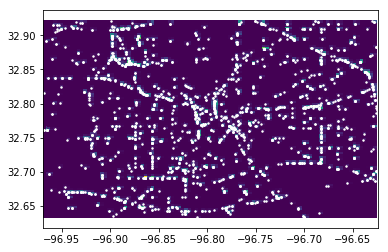

In [11]:
# Crash point visualization
plt.pcolormesh(xx, yy,zz)
plt.scatter(data.iloc[:,1], data.iloc[:,0],s=2, facecolor='white')

In [15]:
# creates dataframes of most dangerous hotspots given the latitude, longitude, and density values
def final_points(xx,yy,zz):
    templist = []
    delete_indexes = []
    for first in range(100):
        for second in range(100):
            templist.append((first,xx[first][second],yy[first][second],zz[first][second]))
    temp = np.array(templist)
    temp = temp[temp[:,3].argsort()]
    temp = np.delete(temp,delete_indexes,0)
    final = temp[-points:]
    final_points = pd.DataFrame({"cluster_number":final[:,0],"latitude":final[:,2],"densities":final[:,3],"longitude":final[:,1],})

    return final_points

In [17]:
final_points_ex = final_points(xx,yy,zz)
final_points_ex.head()

,cluster_number,densities,latitude,longitude
0,79.0,191.220010,32.822252,-96.694567
1,82.0,192.099924,32.714600,-96.684156
2,42.0,192.637406,32.688414,-96.822967
3,66.0,194.394167,32.880442,-96.739681
4,74.0,194.790075,32.894989,-96.711918


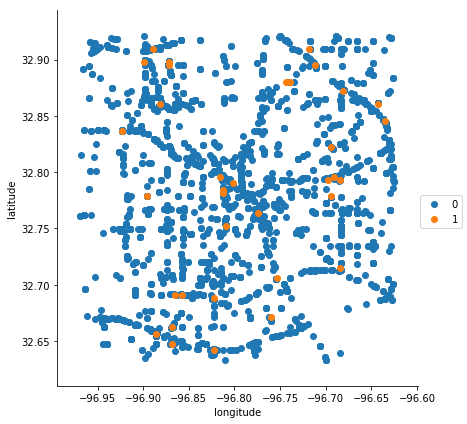

In [19]:
#VISUALIZING HOTSPOTS ON ORIGINAL DATA

hotspot_approved = pd.DataFrame([])
a = 0
while True:
    hotspot_approved = hotspot_approved.append([1],ignore_index=True)
    a += 1
    if a ==len(final_points_ex)*2:
        break
hotspots_final = final_points_ex.join(hotspot_approved)
orig_points = data
orig_points_approved = pd.DataFrame([])

b = 0
while True:
    orig_points_approved = orig_points_approved.append([0],ignore_index=True)
    b += 1
    if b == len(orig_points)*8:
        break
orig_points_final = orig_points.join(orig_points_approved)
orig_points_hotspot = pd.concat([orig_points_final,hotspots_final])
alldata= sns.FacetGrid(orig_points_hotspot,hue=0,size=6)
alldata.map(plt.scatter,'longitude','latitude').add_legend()

In [32]:
def commonCrashCauses(filtered_centers):
    list_all_features= pd.DataFrame([])
    variable_occurence_directory = []
    total_size = 0
    for index,row in filtered_centers.iterrows():
        max_lon = row['longitude'] + 0.02
        min_lon = row['longitude'] - 0.02
        max_lat = row['latitude'] + 0.02
        min_lat = row['latitude'] - 0.02
        temporary = mastertexasDF[(mastertexasDF['latitude']>min_lat)&(mastertexasDF['latitude']<max_lat)&(mastertexasDF['longitude']>min_lon)&(mastertexasDF['longitude']<max_lon)]
        total_size += temporary.size
        ### Create the array of number of occurences
        most_occurences = []
        most_occurences.append("hotspot index number: " + str(index))
        for i in range(4,temporary.shape[1]):
            if i == 12 or i == 13:
                pass
            else:
                most_occurences.append(temporary.columns.values.tolist()[i])
                most_occurences.append(temporary.iloc[:,i].value_counts().index.values[0])
        variable_occurence_directory.append(most_occurences)
        list_all_features = createmasterdata(temporary,list_all_features)
        ### See if the returned points are near clusters
        plt.scatter(list_all_features.iloc[:,12],list_all_features.iloc[:,13],data = list_all_features)
        ### See points near centers 
        list_all_features
    return variable_occurence_directory

79900
[['hotspot index number: 0', 'atmcond', 1, 'accday', 5, 'acchr', 0, 'accmin', 25, 'accmon', 11, 'arf1', 0, 'caseyear', 2012, 'dayofweek', 2, 'manncol', 0, 'speeding', 0, 'travspd', 998, 'dridistract', '0', 'drivisobs', '0', 'surfcond', 1], ['hotspot index number: 1', 'atmcond', 1, 'accday', 23, 'acchr', 3, 'accmin', 10, 'accmon', 6, 'arf1', 0, 'caseyear', 2016, 'dayofweek', 1, 'manncol', 0, 'speeding', 0, 'travspd', 998, 'dridistract', '0', 'drivisobs', '0', 'surfcond', 1], ['hotspot index number: 2', 'atmcond', 1, 'accday', 5, 'acchr', 16, 'accmin', 35, 'accmon', 9, 'arf1', 0, 'caseyear', 2013, 'dayofweek', 1, 'manncol', 6, 'speeding', 1, 'travspd', 998, 'dridistract', '0', 'drivisobs', '0', 'surfcond', 1], ['hotspot index number: 3', 'atmcond', 1, 'accday', 13, 'acchr', 20, 'accmin', 55, 'accmon', 2, 'arf1', 0, 'caseyear', 2010, 'dayofweek', 7, 'manncol', 6, 'speeding', 1, 'travspd', 998, 'dridistract', '0', 'drivisobs', '0', 'surfcond', 1], ['hotspot index number: 4', 'atmcond

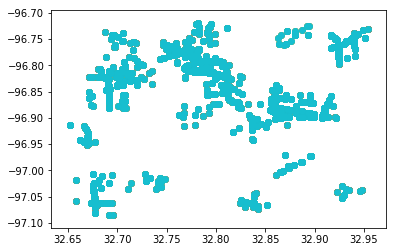

In [33]:
print(commonCrashCauses(final_points(xx,yy,zz)))